In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 39.6 MB/s eta 0:00:00


In [ ]:
import json

import cv2
import numpy as np
import os

from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # 원핫인코딩으로 변경
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def process_frame(image_data):
    # base64 형식의 이미지 데이터를 bytes로 디코딩
    image_bytes = base64.b64decode(image_data)

    # bytes를 NumPy 배열로 변환
    np_arr = np.frombuffer(image_bytes, np.uint8)

    # NumPy 배열을 이미지로 변환
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

    # 이미지 처리 로직 수행
    # 예시로 그레이스케일 변환을 수행합니다.
    # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 처리된 이미지를 다시 base64 형식으로 인코딩
    # _, encoded_img = cv2.imencode('.jpg', gray_img)
    # processed_image_data = base64.b64encode(encoded_img).decode('utf-8')

    return img


def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # 이미지 수정 불가
    results = model.process(image)  # 모델을 사용해 입력 이미지에 대한 예측 수행
    image.flags.writeable = True  # 이미지 다시 수정가능
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return image, results


def draw_landmarks(image, results):  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw right hand connections


def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                              )


def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in
                     results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[res.x, res.y, res.z] for res in
                   results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in
                   results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(
        21 * 3)
    return np.concatenate([pose, lh, rh])

In [ ]:

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/drive/MyDrive/캡스톤/key_data')

# Actions that we try to detect
actions = np.array(['나', '너', '많다', '맞다', '모르다', '수고하다', '슬퍼요', '아니요', '안녕하세요', '인사'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}
print(label_map)




{'나': 0, '너': 1, '많다': 2, '맞다': 3, '모르다': 4, '수고하다': 5, '슬퍼요': 6, '아니요': 7, '안녕하세요': 8, '인사': 9}


In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in range(1, no_sequences+1):
      res = np.load(os.path.join(DATA_PATH, action, action+"_"+"{}.npy".format(sequence)))
        # window = []
        # for frame_num in range(1, sequence_length+1):  # seqeunce_length = 30
        #     res = np.load(os.path.join(DATA_PATH, action, action+"_"+"{}.npy".format(frame_num)))
        #     #(30, 258)
        #     window.append(res)
      sequences.append(res)
      labels.append(label_map[action])

np.array(sequences).shape
# (300arrays, 30 frames in each one, 각각 258개의 key points )

X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

# 모델 생성
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(30, 258)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))  # 'actions'에 대한 정보가 누락됨
# LSTM
'''
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(30, 258)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
'''
model = Sequential()
model.add(GRU(64, input_shape=(30, 258), return_sequences=True))
model.add(GRU(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
'''
model = Sequential()
model.add(SimpleRNN(64, input_shape=(30, 258), return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
# optimizer 정의
optimizer = Adam(learning_rate=0.001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# EarlyStopping 콜백을 사용하여 모델 학습
history = model.fit(X_train, y_train, epochs=2000, callbacks=[early_stopping], validation_data=(X_test, y_test), verbose=1)

Epoch 1/2000
7/7 [==============================] - 0s 18ms/step - loss: 0.4115 - categorical_accuracy: 0.8476 - val_loss: 0.2739 - val_categorical_accuracy: 0.8667
Epoch 2/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2609 - categorical_accuracy: 0.9095 - val_loss: 0.2637 - val_categorical_accuracy: 0.9444
Epoch 3/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.2205 - categorical_accuracy: 0.9524 - val_loss: 0.1556 - val_categorical_accuracy: 0.9667
Epoch 4/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.1787 - categorical_accuracy: 0.9619 - val_loss: 0.1415 - val_categorical_accuracy: 0.9778
Epoch 5/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.1756 - categorical_accuracy: 0.9571 - val_loss: 0.0977 - val_categorical_accuracy: 0.9778
Epoch 6/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1505 - categorical_accuracy: 0.9619 - val_loss: 0.1371 - val_categorical_accuracy: 0.9556
Epoch 7/20

In [ ]:
model.save_weights("/content/drive/MyDrive/캡스톤/model_weight")

In [ ]:
model.save("/content/drive/MyDrive/캡스톤/model_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.1758 - categorical_accuracy: 0.9222


[0.17578750848770142, 0.9222221970558167]

In [ ]:
print(history.history)

{'loss': [0.41154399514198303, 0.2609196901321411, 0.22045622766017914, 0.17871417105197906, 0.17564165592193604, 0.15045666694641113, 0.12945815920829773, 0.16189871728420258], 'categorical_accuracy': [0.8476190567016602, 0.9095237851142883, 0.9523809552192688, 0.961904764175415, 0.9571428298950195, 0.961904764175415, 0.9666666388511658, 0.9333333373069763], 'val_loss': [0.27392342686653137, 0.2637026906013489, 0.15558244287967682, 0.14154714345932007, 0.09771450608968735, 0.13712695240974426, 0.17578750848770142, 0.07618756592273712], 'val_categorical_accuracy': [0.8666666746139526, 0.9444444179534912, 0.9666666388511658, 0.9777777791023254, 0.9777777791023254, 0.9555555582046509, 0.9222221970558167, 0.9888888597488403]}


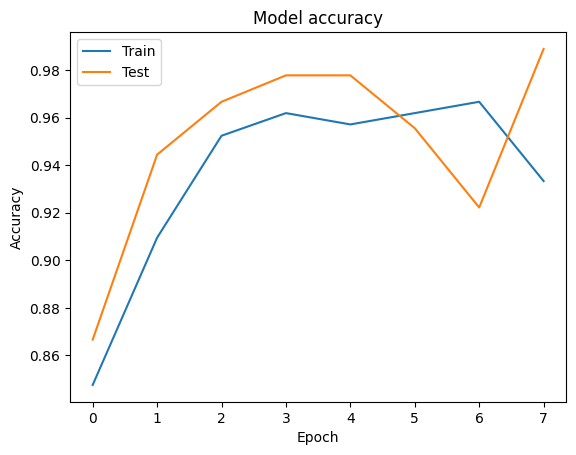

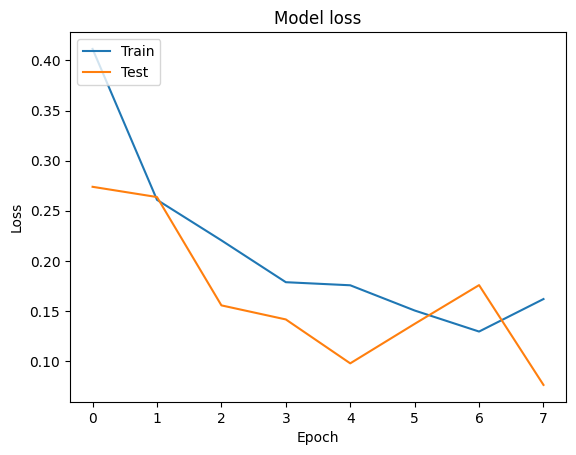

In [ ]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/캡스톤/model_full.h5')

In [ ]:
test = np.load("/content/drive/MyDrive/캡스톤/key_data/인사/인사_43.npy")

In [ ]:
test_arr = []
test_arr.append(test)
testt = np.array(test_arr)

In [ ]:
y_predict = new_model.predict(testt)
result = actions[np.argmax(y_predict)]
print(result)

1/1 [==============================] - 0s 25ms/step
인사


In [ ]:
y_predict.shape

(90, 10)

In [ ]:
y_test

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0,